In [1]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import glob, os

# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.externals import joblib

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('stopwords.txt', 'r') as f:
    en_stop = f.readlines()
en_stop = [w.replace('\n', '') for w in en_stop]

In [3]:
data = []
doc_name = []
for file in glob.glob("data/Macbeth/*.txt"):
    f = open(file, "r")
    text = f.read()
    data.append(text)
    name = file.split('/')[2].split('.txt')[0]
    doc_name.append(name)

In [4]:
# Remove new line characters
data = [re.sub('\n', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [6]:
p_stemmer = PorterStemmer()

# list for tokenized documents in loop
texts = []

# loop through document list
for tokens in data_words:
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]

    # add tokens to list
    texts.append(stopped_tokens)

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

tf_feature_names = vectorizer.get_feature_names()

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  47.43589743589743 %


In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',
                                      learning_decay=0.7,
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1075.4528220523619
Perplexity:  14.04673839566075
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [12]:
# Define Search Param
search_params = {'n_components': [6, 7, 8, 9, 10, 11, 12], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/mehmetcanyavuz/anaconda2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [6, 7, 8, 9, 10, 11, 12], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Save and load model

In [13]:
filename = 'models/macbeth_optimized_model.sav'

In [ ]:
model = joblib.load(filename)
print(model)

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 6}
Best Log Likelihood Score:  -454.38503575214827
Model Perplexity:  16.361121846630006


In [16]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [6, 7, 8, 9, 10, 11, 12]
log_likelyhoods_5 = model.cv_results_['mean_test_score'][:7].tolist()
log_likelyhoods_7 = model.cv_results_['mean_test_score'][7:14].tolist()
log_likelyhoods_9 = model.cv_results_['mean_test_score'][14:21].tolist()

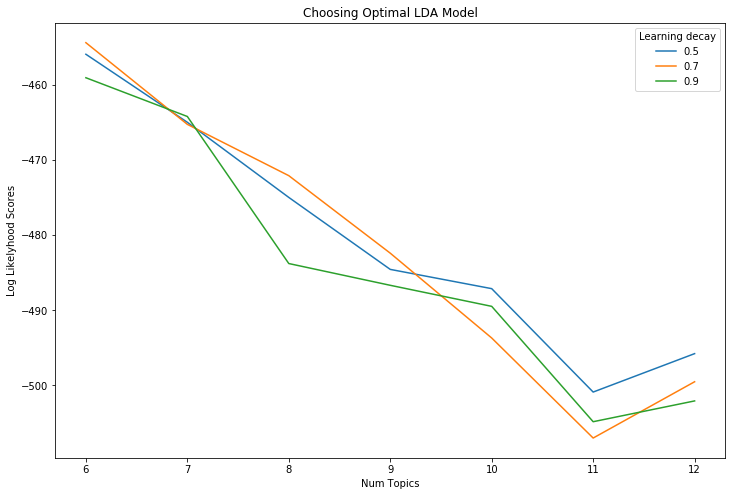

In [17]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [18]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(best_lda_model, tf_feature_names, no_top_words)

Topic 0:
night king stand speak time hand macbeth sleep thane live set death ill
Topic 1:
ill king time live sleep night death stand macbeth speak thane set hand
Topic 2:
speak macbeth king time ill set death thane stand hand night live sleep
Topic 3:
stand set sleep death time ill thane night live king hand macbeth speak
Topic 4:
macbeth thane ill death night live hand speak king time stand sleep set
Topic 5:
hand time night sleep speak thane king death live stand ill set macbeth


In [19]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = doc_name
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'red' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.sort_index(0).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
ALL,0.03,0.03,0.03,0.03,0.03,0.83,5
ANGUS,0.04,0.04,0.04,0.04,0.04,0.79,5
BANQUO,0.97,0.01,0.01,0.01,0.01,0.01,0
DUNCAN,0.02,0.02,0.02,0.02,0.92,0.02,4
Doctor,0.02,0.02,0.02,0.02,0.02,0.92,5
First Murderer,0.03,0.03,0.03,0.83,0.03,0.03,3
First Witch,0.01,0.67,0.01,0.01,0.29,0.01,1
Gentlewoman,0.9,0.02,0.02,0.02,0.02,0.02,0
HECATE,0.02,0.02,0.02,0.02,0.9,0.02,4
LADY MACBETH,0,0,0,0,0,0.98,5


In [22]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=model.best_params_['n_components'], random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x_coords = lda_output_svd[:, 0]
y_coords = lda_output_svd[:, 1]
clusters_dimreduced = KMeans(n_clusters=3).fit_predict(lda_output_svd)
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.19  0.31  0.14  0.16  0.24  0.87]
 [ 0.77  0.36  0.08  0.11  0.3  -0.41]]
Perc of Variance Explained: 
 [0.11 0.22]


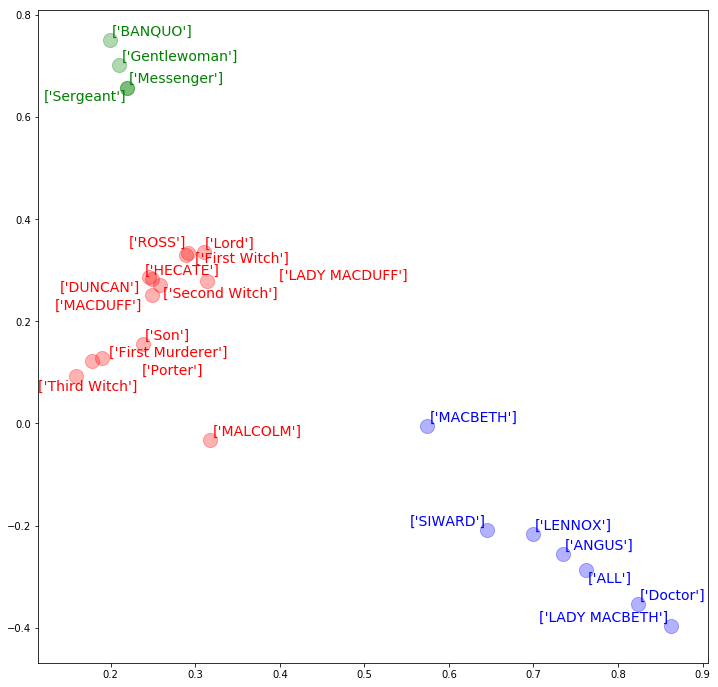

In [23]:
from adjustText import adjust_text
# Plot
plt.figure(figsize=(12, 12))

for i,doc in enumerate(doc_name):
    x = x_coords[i]
    y = y_coords[i]
    genre = doc[0][:-1]
    if clusters_dimreduced[i] == 0:
        plt.scatter(x, y, marker='o', color='red', alpha=0.3, s=200)
    elif clusters_dimreduced[i] == 1:
        plt.scatter(x, y, marker='o', color='blue', alpha=0.3, s=200)
    elif clusters_dimreduced[i] == 2:
        plt.scatter(x, y, marker='o', color='green', alpha=0.3, s=200)
    elif clusters_dimreduced[i] == 3:
        plt.scatter(x, y, marker='o', color='black', alpha=0.3, s=200)
        
texts = []    
for i,doc in enumerate(doc_name):
    x = x_coords[i]
    y = y_coords[i]
    doc = doc.split("-")
    if clusters_dimreduced[i] == 0:
        texts.append(plt.text(x, y, doc, fontsize=14, color="red"))
    elif clusters_dimreduced[i] == 1:
        texts.append(plt.text(x, y, doc, fontsize=14, color="blue"))
    elif clusters_dimreduced[i] == 2:
        texts.append(plt.text(x, y, doc, fontsize=14, color="green"))
    elif clusters_dimreduced[i] == 3:
        texts.append(plt.text(x, y, doc, fontsize=14, color="black"))
        
adjust_text(texts)        
plt.show()